In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ../analysis/

/srv/data/home/jlee782/segmentation/analysis


In [3]:
%load_ext autoreload
%autoreload 2
from preprocessing import *

/home/jlee782/.local/lib/python2.7/site-packages/pandas/io/parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
  ParserWarning)


In [4]:
# Task difficulty
object_lst = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47]
type_one_task_ambiguity = [15,20,22,27,31,40,41,42,47] #wrong object annotation
type_two_task_ambiguity = [1,4,7,8,9,10,18,20,21,25,28,29,30,31,32,33,34,35] #missing region

all_hard_tasks = list(set(np.concatenate((type_one_task_ambiguity,type_two_task_ambiguity))))
easy_tasks = [objid  for objid in object_lst if objid not in all_hard_tasks]

In [5]:
# PDF('../bb_object_pdfs/bb_object_{}.pdf'.format(obj),size=(500,300))

In [119]:
wids_counts_dict

Counter({3: 62,
         48: 8,
         52: 8,
         68: 8,
         110: 8,
         114: 8,
         133: 64,
         135: 8,
         140: 8,
         141: 8,
         146: 8,
         148: 12,
         149: 8,
         161: 8,
         169: 10,
         181: 62,
         184: 8,
         187: 8,
         193: 8,
         196: 8,
         199: 8,
         201: 8,
         208: 8,
         219: 8,
         222: 8,
         228: 8,
         230: 8,
         234: 62,
         241: 8,
         246: 8,
         247: 8,
         250: 8,
         252: 8,
         256: 8})

obj 1 : Not Type 1 error
obj 4 : Not Type 1 error
obj 7 : Not Type 1 error
obj 7 : Not Type 2 error
False False
obj 8 : Not Type 1 error
obj 8 : Not Type 2 error
False False
obj 9 : Not Type 1 error
obj 10 : Not Type 1 error


/home/jlee782/.local/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


obj 20 : Not Type 2 error
False False
obj 25 : Not Type 1 error
obj 25 : Not Type 2 error
False False
obj 28 : Not Type 1 error
obj 28 : Not Type 2 error
False False
obj 29 : Not Type 2 error
False False
obj 30 : Not Type 1 error
obj 31 : Not Type 2 error
True False
obj 32 : Not Type 1 error
obj 32 : Not Type 2 error
False False
obj 33 : Not Type 1 error
obj 33 : Not Type 2 error
True False
obj 34 : Not Type 1 error
obj 35 : Not Type 1 error
obj 35 : Not Type 2 error
False True


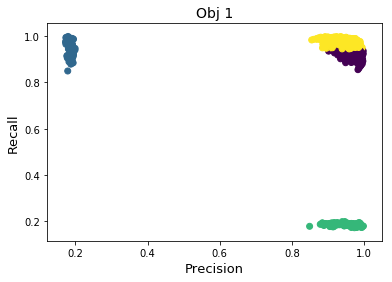

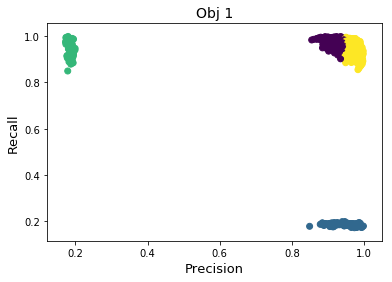

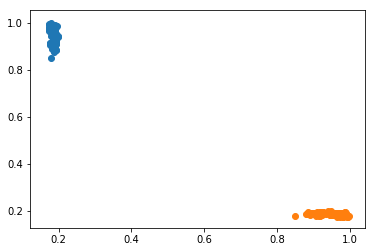

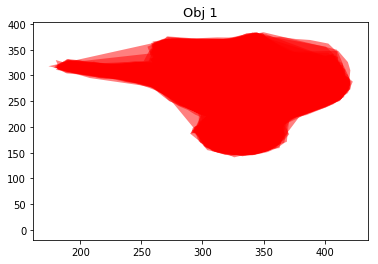

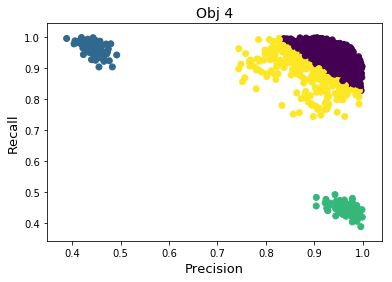

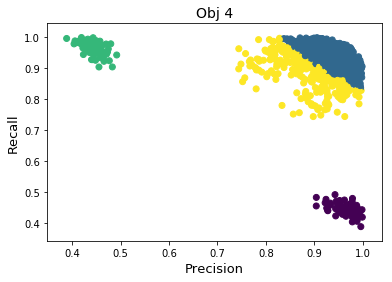

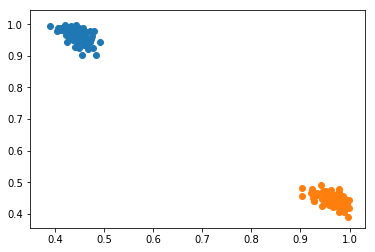

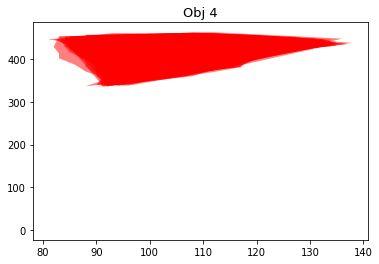

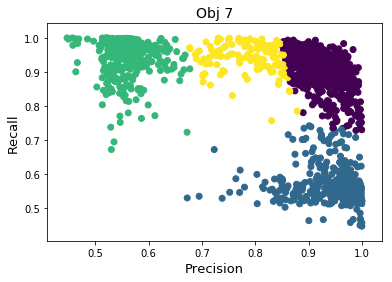

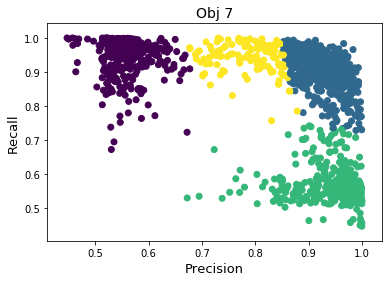

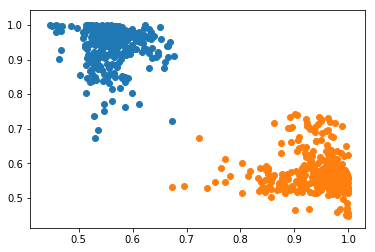

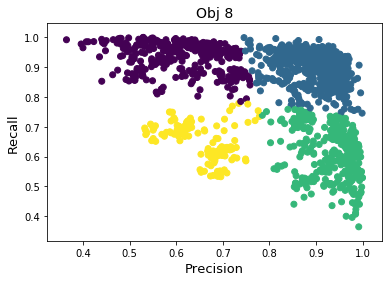

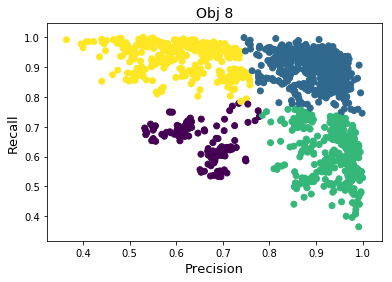

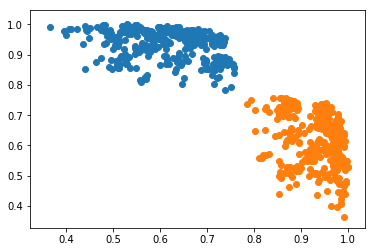

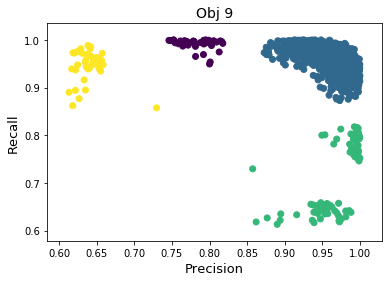

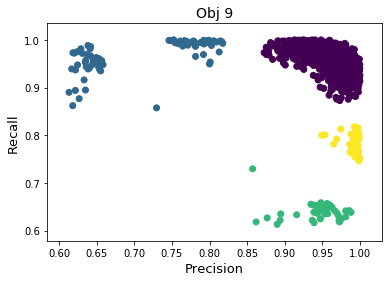

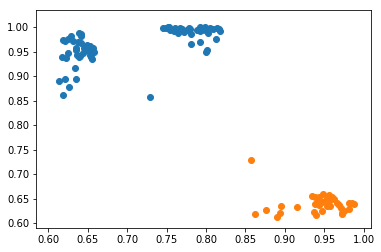

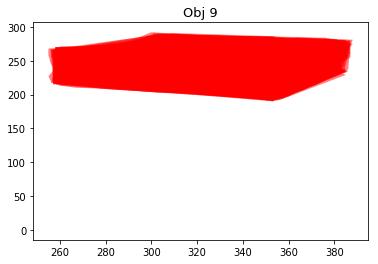

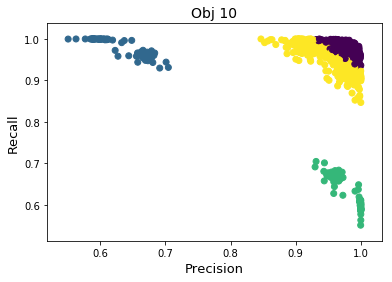

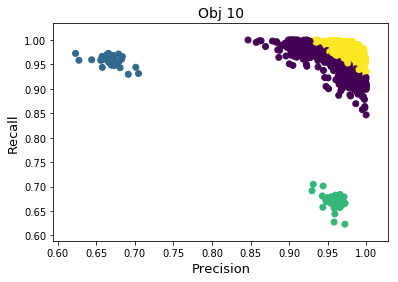

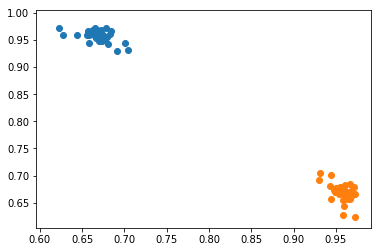

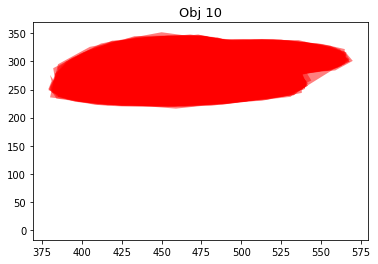

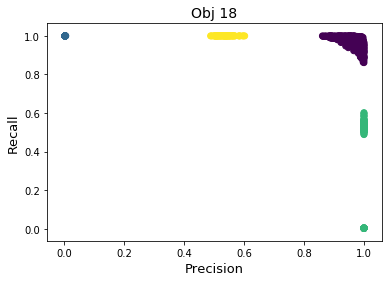

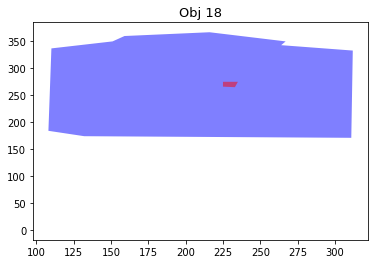

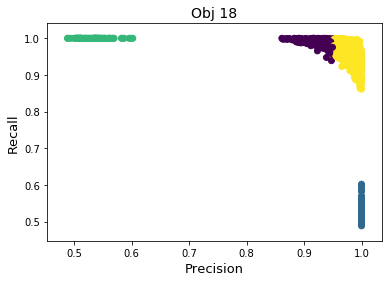

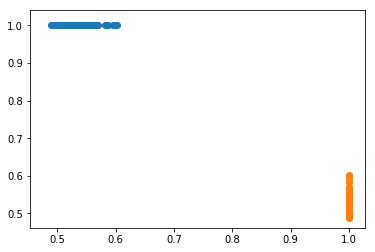

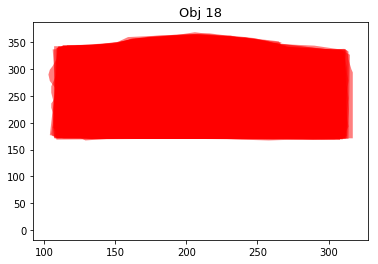

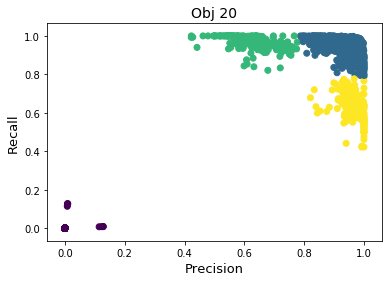

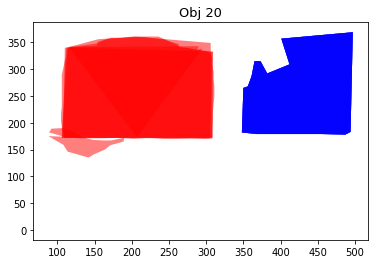

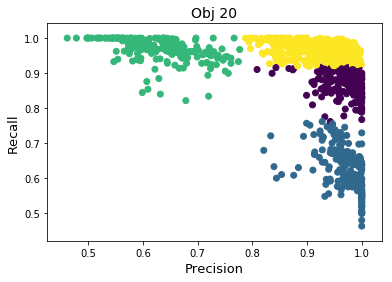

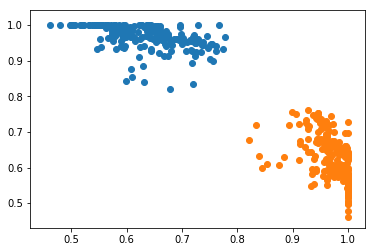

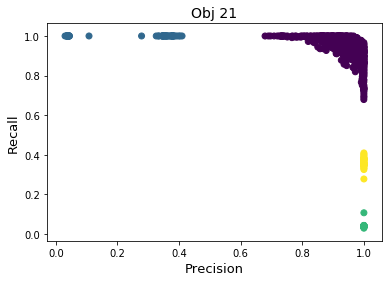

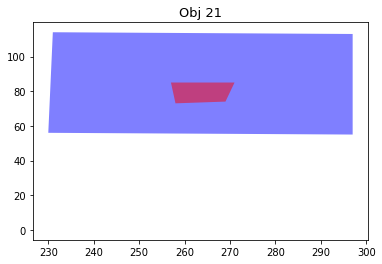

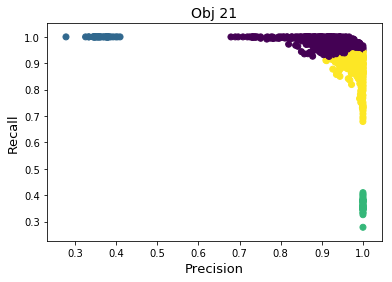

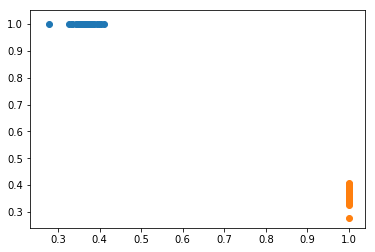

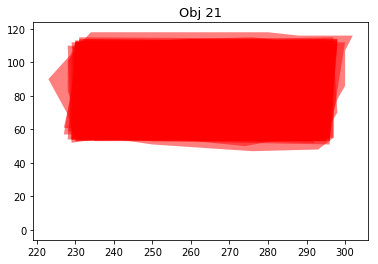

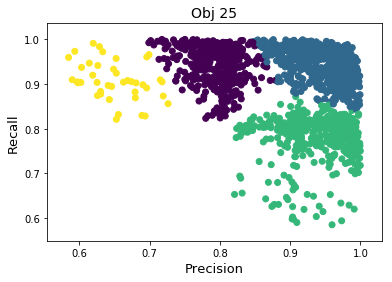

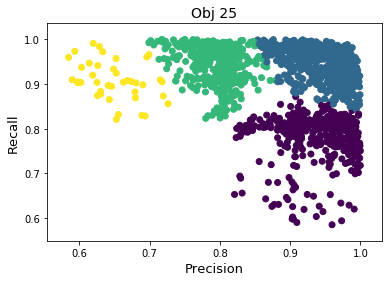

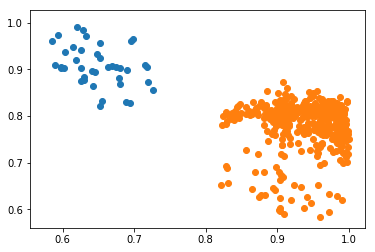

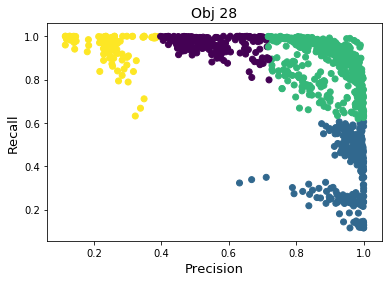

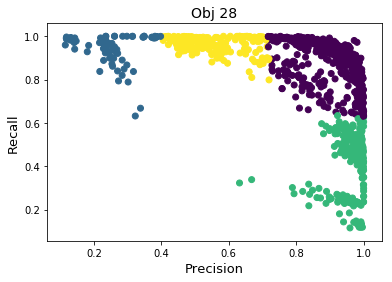

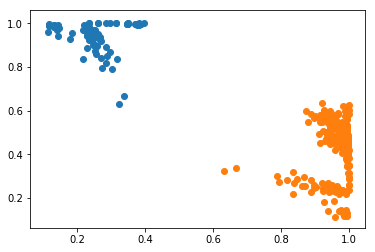

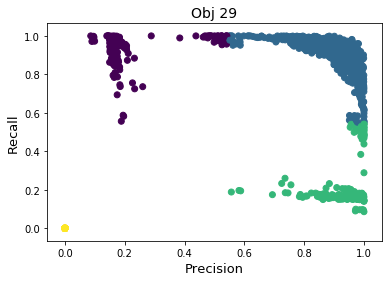

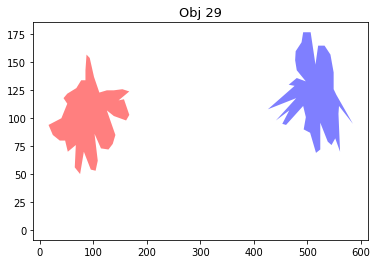

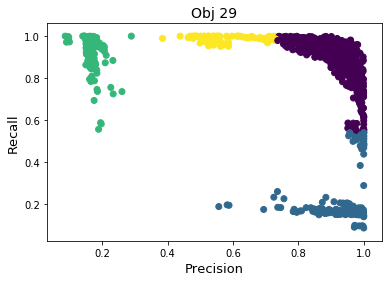

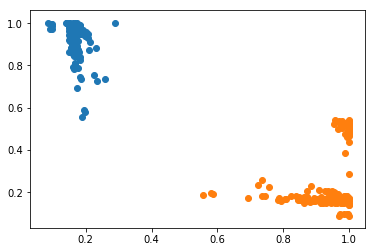

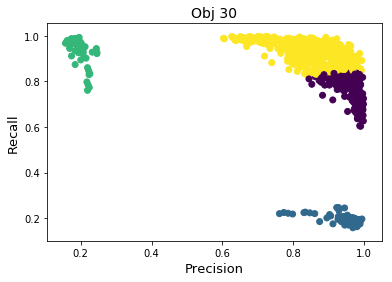

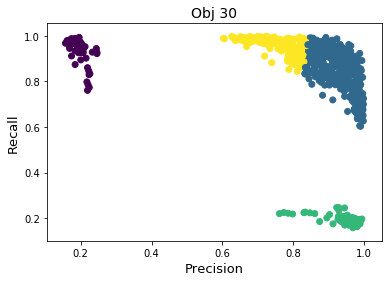

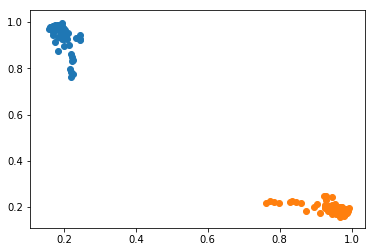

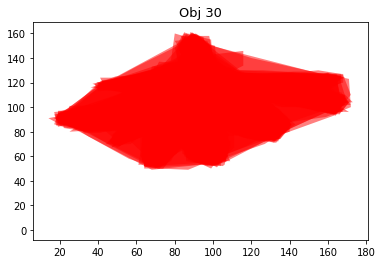

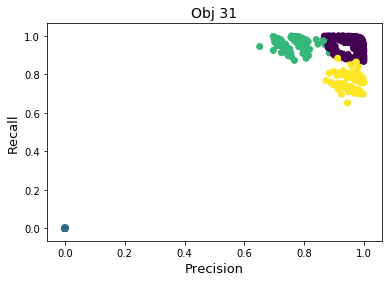

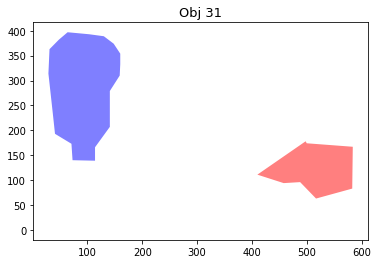

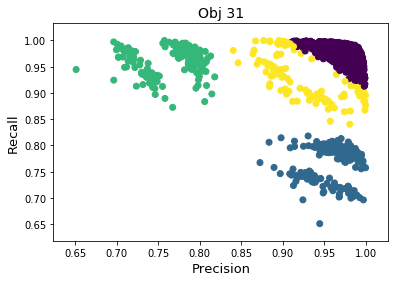

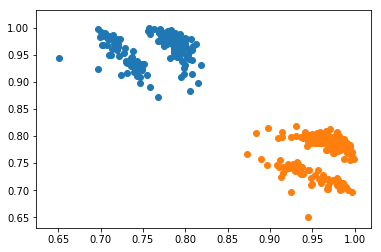

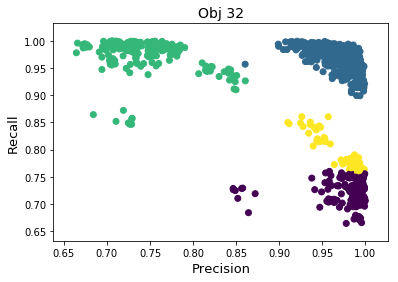

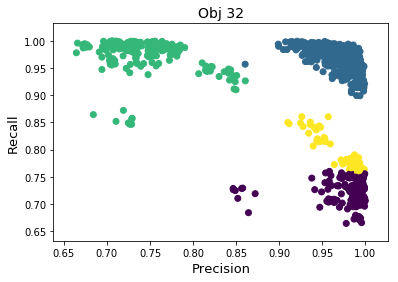

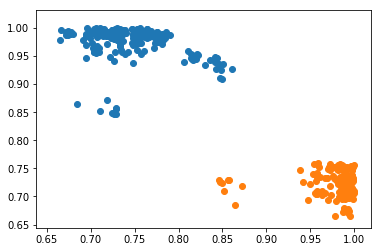

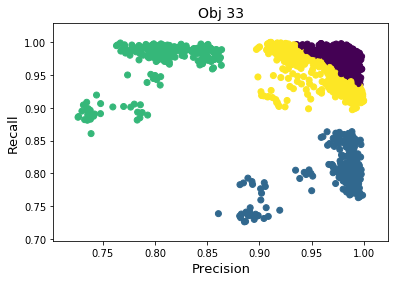

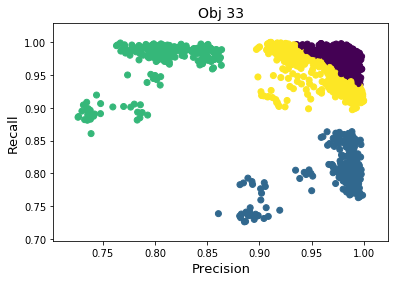

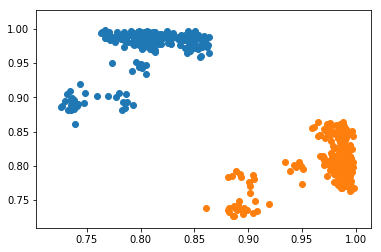

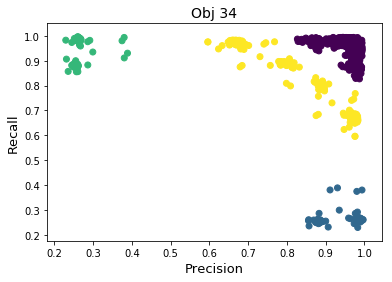

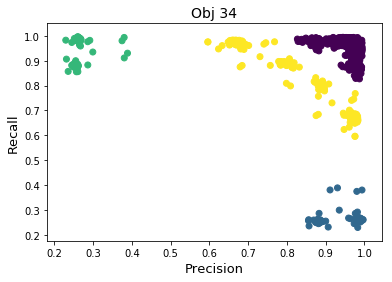

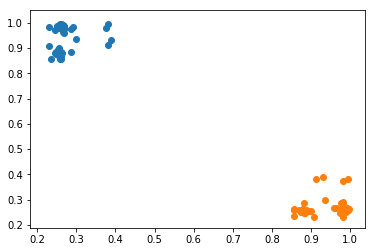

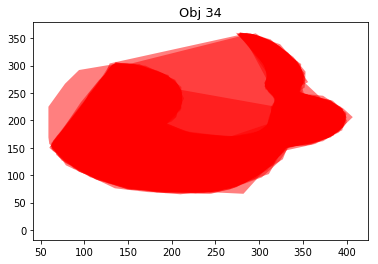

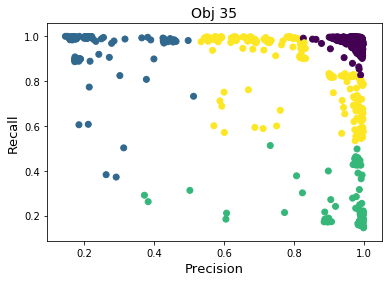

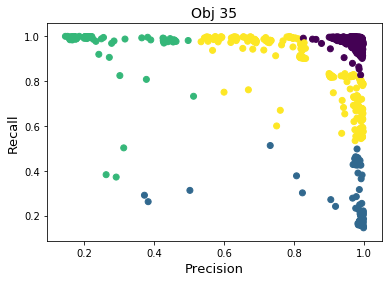

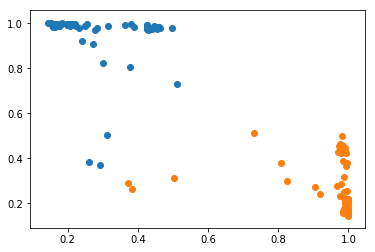

In [77]:
bad_worker_records =[]
for obj in object_lst:
    # First pass, get rid of type 1 error
    prj_matrix,worker_ijdxs = compute_prjs(obj)
    kmeans,ypred = cluster_and_plot(obj,prj_matrix)
    bb_objects = bb_info[bb_info["object_id"]==obj]
    type1_error_cluster = np.where(kmeans.cluster_centers_[:,2]<0.1)[0]
    if len(type1_error_cluster)==0:
        print "obj",obj,": Not Type 1 error"
    else:
        type1_error_wids = np.where(ypred==type1_error_cluster[0])[0]
        wids_counts_dict = Counter(worker_ijdxs[type1_error_wids].flatten())
        mode = scipy.stats.mode(wids_counts_dict.values()).mode[0]
        bad_idx = np.where(wids_counts_dict.values()!=mode)[0]
        bad_widx1 = np.array(wids_counts_dict.keys())[bad_idx]
        plt.figure()
        plt.title("Obj {}".format(obj),fontsize=13)
        for widx in bad_widx1:
            plot_coords(ground_truth_T(obj),color="blue",fill_color="blue",reverse_xy=True)
            plot_coords(worker_polygon(bb_objects,widx),reverse_xy=True)
        for bwidx in bad_widx1:
            bad_worker_records.append([obj,bwidx,1]) #obj,bad worker id, error type 1

    # Second pass, get rid of type 2 error
    prj_matrix,worker_ijdxs = compute_prjs(obj,exclude_lst=bad_widx1)
    kmeans,ypred = cluster_and_plot(obj,prj_matrix)
    bb_objects = bb_info[bb_info["object_id"]==obj]
    i = kmeans.cluster_centers_[:,0].argmin() #lowest precision cluster
    j = kmeans.cluster_centers_[:,1].argmin() #highest precision cluster

    idx = np.where(ypred==i)[0]
    jdx = np.where(ypred==j)[0]
    plt.figure()
    plt.scatter(prj_matrix[idx,0],prj_matrix[idx,1])
    plt.scatter(prj_matrix[jdx,0],prj_matrix[jdx,1])

    all_bad_worker_pairs = np.concatenate([worker_ijdxs[idx],worker_ijdxs[jdx]])
    wids_counts_dict = Counter(all_bad_worker_pairs.flatten())
    # Type 2 object errors where only a few workers make mistake are often in the form of high number of modes with a few mistaken worker having very high count
    count_of_voted_pairs = Counter(wids_counts_dict.values()) 

    total_datapoints_in_bad_clusters = len(all_bad_worker_pairs)*2

    flag1 = len(count_of_voted_pairs)<4 #number of distinct values is less than 4
    flag2= max(count_of_voted_pairs.keys())> total_datapoints_in_bad_clusters*0.1 #the large counts must be larger than 10% of the total datapoints in the bad clusters

    if flag1 and flag2:
        mode = scipy.stats.mode(wids_counts_dict.values()).mode[0]
        bad_idx = np.where(wids_counts_dict.values()!=mode)[0]
        bad_widx2 = np.array(wids_counts_dict.keys())[bad_idx]
        plt.figure()
        plt.title("Obj {}".format(obj),fontsize=13)
        bad_widx = np.concatenate([bad_widx1,bad_widx2])
        good_widx = [wid for wid in bb_objects.worker_id.unique() if wid not in bad_widx ]
#         for widx in bad_widx:
#             plot_coords(worker_polygon(bb_objects,widx),reverse_xy=True)
#             plot_coords(ground_truth_T(obj),color="blue",fill_color="blue",reverse_xy=True)
        for widx in good_widx:
            plot_coords(worker_polygon(bb_objects,widx),reverse_xy=True)
        for bwidx in bad_widx2:
            bad_worker_records.append([obj,bwidx,2]) #obj,bad worker id, error type 1
    else:
        print "obj",obj,": Not Type 2 error"
        print flag1,flag2
df = pd.DataFrame(bad_worker_records)
df.to_csv("bad_worker_records.csv")

In [85]:
worker_lst

[1, 34, 4, 9, 10, 18, 20, 21, 29, 30, 31]

In [86]:
bad_worker_records

array([[  1,   3,   2],
       [  1, 146,   2],
       [  1, 234,   2],
       [  4, 208,   2],
       [  4, 223,   2],
       [  9,  82,   2],
       [  9, 234,   2],
       [ 10, 147,   2],
       [ 18, 114,   1],
       [ 18, 187,   2],
       [ 18,  82,   2],
       [ 20,   8,   1],
       [ 20,  16,   1],
       [ 20,  38,   1],
       [ 20, 174,   1],
       [ 20, 200,   1],
       [ 20,  82,   1],
       [ 21, 114,   1],
       [ 21, 178,   2],
       [ 29, 187,   1],
       [ 30, 263,   2],
       [ 30, 114,   2],
       [ 30, 147,   2],
       [ 31,  34,   1],
       [ 34, 140,   2],
       [ 34, 147,   2]])

In [91]:
bad_worker_record

array([1, 3, 2])

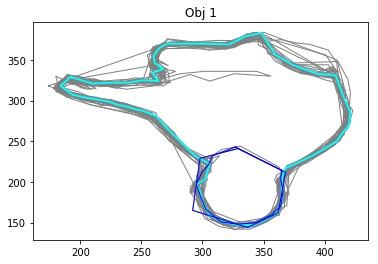

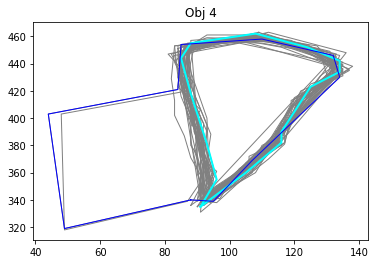

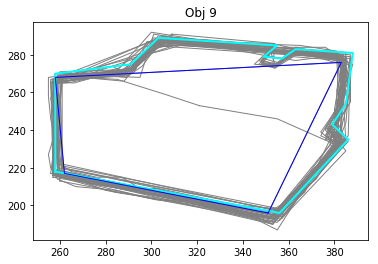

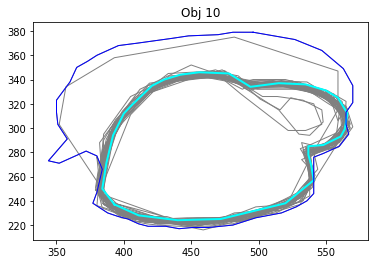

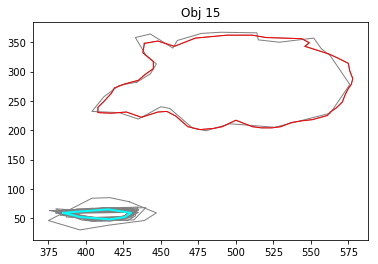

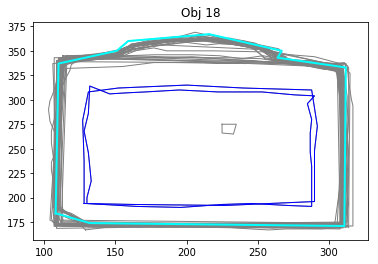

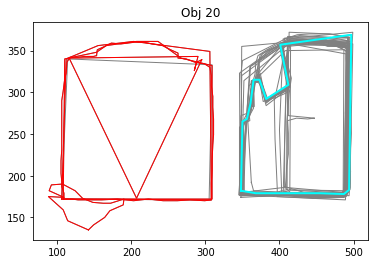

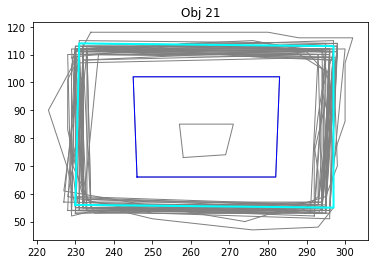

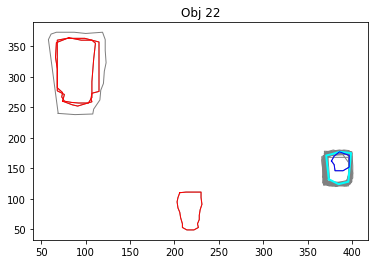

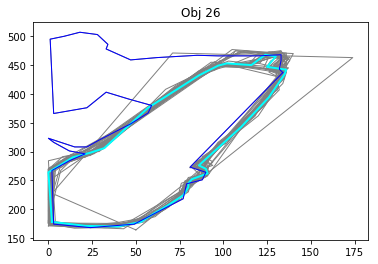

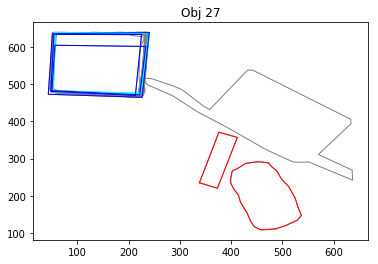

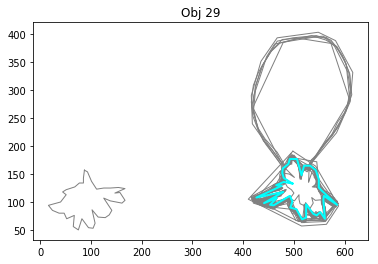

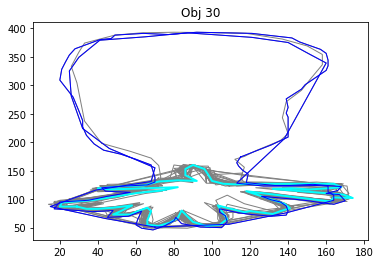

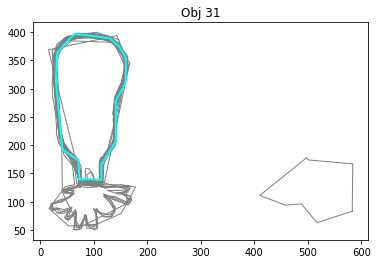

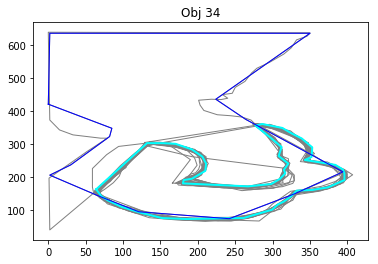

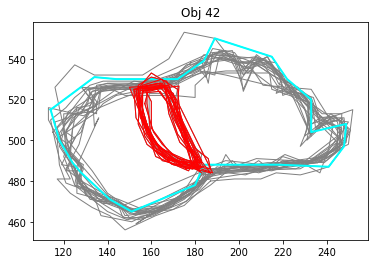

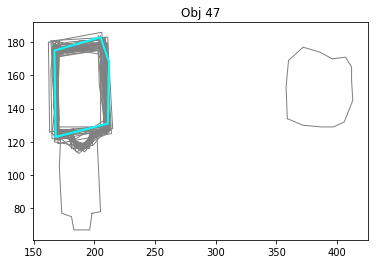

In [118]:
bad_worker_records = pd.read_csv("bad_worker_records.csv",index_col=0).as_matrix()

worker_lst = list(set(bad_worker_records[:,0]))
bad_worker_records = np.array(bad_worker_records)
curr_obj = -1
for bad_worker_record in bad_worker_records:
    #print bad_worker_record
    if curr_obj!=bad_worker_record[0]:
        #print "here"
        curr_obj = bad_worker_record[0]
        bb_objects = bb_info[bb_info["object_id"]==curr_obj]
        plt.figure()
        plt.title("Obj {}".format(curr_obj))
        
        for widx in bb_objects.worker_id.unique():
            plot_coords(worker_polygon(bb_objects,widx),reverse_xy=True,color="grey",fill_color="")
        plot_coords(ground_truth_T(curr_obj),color="cyan",lw=2,reverse_xy=True,fill_color="")
    else:
        widx = bad_worker_record[1]
        err_type = bad_worker_record[2]
        if err_type==1:
            plot_coords(worker_polygon(bb_objects,widx),reverse_xy=True,color="red",fill_color="")
        elif err_type==2:
            plot_coords(worker_polygon(bb_objects,widx),reverse_xy=True,color="blue",fill_color="")

# #         for widx in bad_widx:
# #             plot_coords(worker_polygon(bb_objects,widx),reverse_xy=True)
# #             plot_coords(ground_truth_T(obj),color="blue",fill_color="blue",reverse_xy=True)

Something that is type 2 error: 18 (and correctly identified)

In [49]:
bad_worker_records

[[18, 114, 1], [18, 187, 2], [18, 82, 2]]

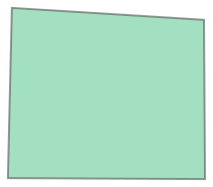

In [54]:
worker_polygon(bb_objects,81)

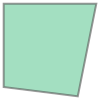

In [53]:
worker_polygon(bb_objects,114)

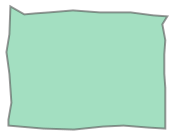

In [52]:
worker_polygon(bb_objects,187)

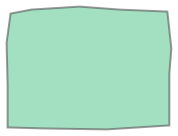

In [50]:
worker_polygon(bb_objects,82)

In [48]:
wids_counts_dict

Counter({3: 4,
         6: 4,
         9: 4,
         32: 4,
         33: 4,
         46: 4,
         54: 4,
         81: 4,
         82: 72,
         116: 4,
         135: 4,
         156: 4,
         169: 4,
         172: 4,
         174: 4,
         175: 4,
         181: 4,
         184: 4,
         187: 72,
         189: 4,
         193: 4,
         194: 4,
         196: 4,
         199: 4,
         200: 4,
         201: 4,
         203: 4,
         205: 4,
         208: 4,
         209: 4,
         210: 4,
         211: 4,
         214: 4,
         217: 4,
         218: 4,
         219: 4,
         225: 4,
         256: 4})

In [56]:
# Type 2 object errors where only a few workers make mistake are often in the form of high number of modes with a few mistaken worker having very high count
count_of_voted_pairs = Counter(wids_counts_dict.values()) 

total_datapoints_in_bad_clusters = len(all_bad_worker_pairs)*2

flag1 = len(count_of_voted_pairs)<4 #number of distinct values is less than 4
flag2= max(count_of_voted_pairs.keys())> total_datapoints_in_bad_clusters*0.1 #the large counts must be larger than 10% of the total datapoints in the bad clusters

flag1 and flag2

28.8

In [65]:
sum(wids_counts_dict.values())

288

72


Something that is type 2 error: 10 (and correctly identified)

In [40]:
Counter(wids_counts_dict.values())

Counter({4: 39, 78: 2})

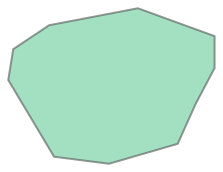

In [44]:
worker_polygon(bb_objects,147)

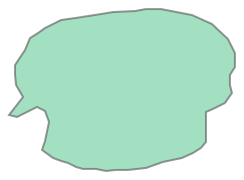

In [45]:
worker_polygon(bb_objects,114)

In [42]:
bad_worker_records

[[10, 147, 2], [10, 114, 2]]

In [41]:
wids_counts_dict

Counter({2: 4,
         46: 4,
         52: 4,
         54: 4,
         114: 78,
         116: 4,
         131: 4,
         133: 4,
         135: 4,
         137: 4,
         139: 4,
         140: 4,
         142: 4,
         146: 4,
         147: 78,
         148: 4,
         149: 4,
         156: 4,
         159: 4,
         161: 4,
         167: 4,
         169: 4,
         170: 4,
         175: 4,
         184: 4,
         187: 4,
         193: 4,
         199: 4,
         204: 4,
         205: 4,
         218: 4,
         219: 4,
         223: 4,
         226: 4,
         230: 4,
         233: 4,
         235: 4,
         239: 4,
         240: 4,
         260: 4,
         261: 4})

Something that is not type 2 error: 15

In [19]:
mean(wids_counts_dict.values())

13.794871794871796

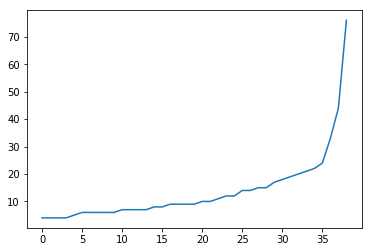

In [17]:
plt.plot(sorted(wids_counts_dict.values()))